# Лабораторная работа 1 по предмету Введение в машинное обучение
Выполнил: студент группы 3311 Шарпинский Денис

Датасет: https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv

### План выполнения работы
Поскольку ранее я имел опыт выполнения двух работ по аналогичному очному предмету, то я буду делать следующие действия:

1. Анализ данных:
  - какие признаки больше остальных коррелируют с таргетом?
  - какие признаки необходимо преобразовать в численный формат?
2. Подготовка данных:
  - удаление / заполнение пропусков
  - преобразование данных в нужные форматы
3. Обучение модели:
  - разделить дата фрейм на две части: таргет и данные
  - подготовить сетку параметров для грид сёрча и кросс-валидацию (будет использован рандом форест)
  - (опционально) необходимо разбить подготовленные тренировочные данные на две части в соотношении 80 / 20, чтобы оставшиеся 20% использовать для валидации и оценки
  - обучить саму модель 
  - (опционально) если ранее было сделано разделение 80 / 20, то можно сразу просмотреть точность и площадь под roc-auc

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [12]:
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')
print(f"Train: {df_train_raw.shape}")
print(f"Test: {df_test_raw.shape}")
print("Данные загружены")

Train: (8693, 14)
Test: (4277, 13)
Данные загружены


In [13]:
print("head\n\n")
print(df_train_raw.head(5))
print("\n\ninfo\n\n")
df_train_raw.info()
print("\n\ndescribe\n\n")
print(df_train_raw.describe())

head


  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         Tr

### Анализ
Из выведенной выше информации о датасете, сразу можно выполнить очевидные преобразования категориальных признаков (по типу заменить True | False на 0 | 1), чтобы сразу увидеть сильные связи.

Распределение целевой переменной Transported:
Transported
True     4378
False    4315
Name: count, dtype: int64


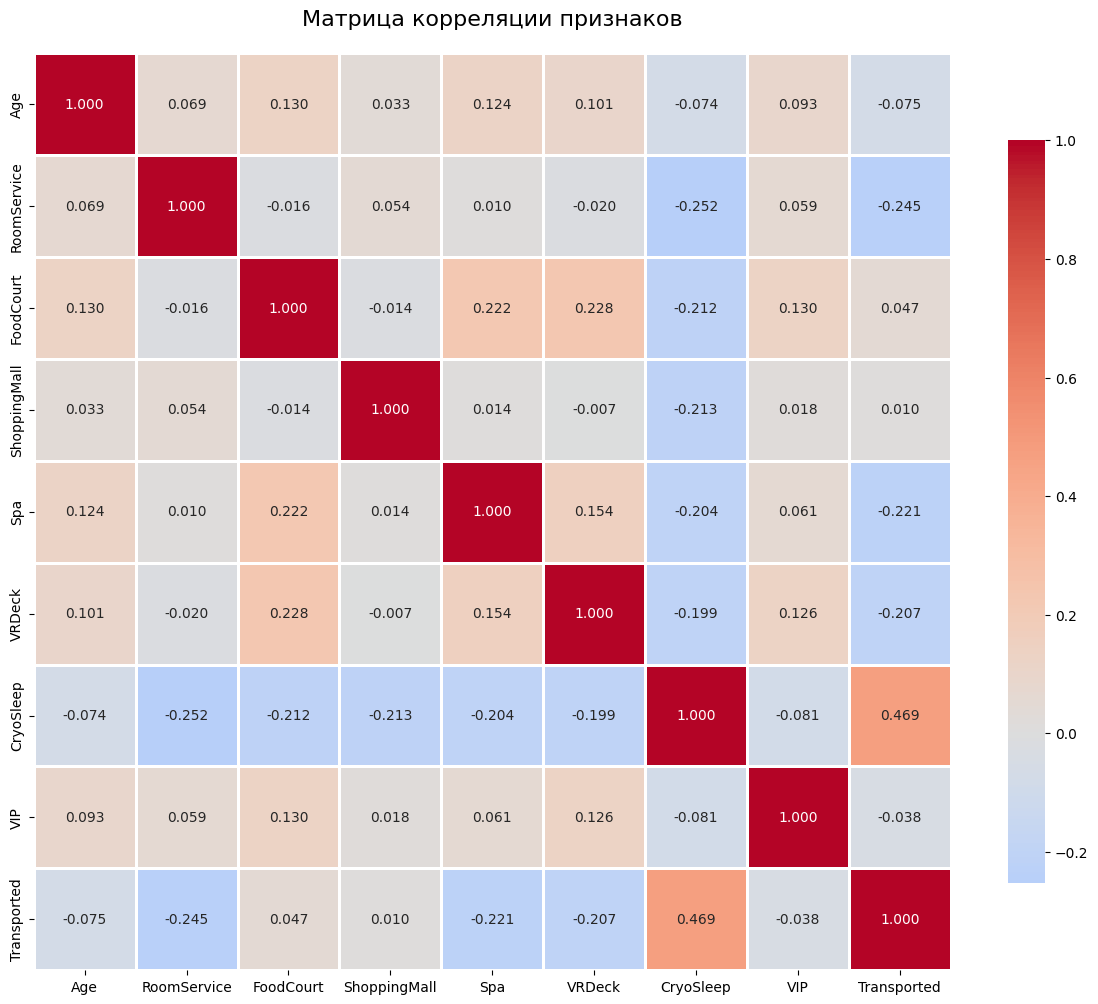

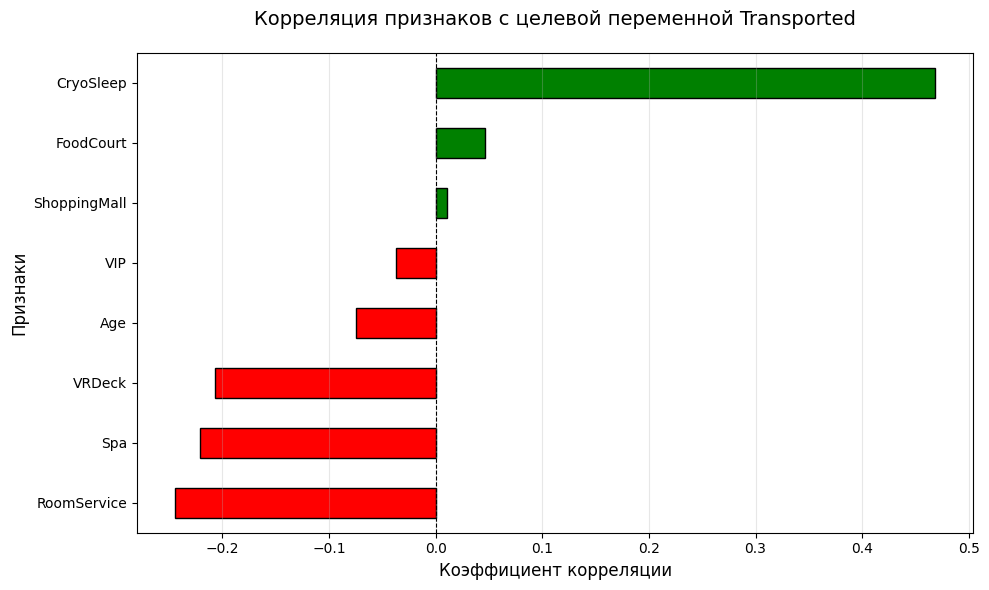

In [14]:
df = df_train_raw.copy()

print("Распределение целевой переменной Transported:")
print(df['Transported'].value_counts())

df_corr = df.copy()
df_corr['Transported'] = df_corr['Transported'].astype(int)
df_corr['CryoSleep'] = df_corr['CryoSleep'].map({'True': 1, 'False': 0, True: 1, False: 0})
df_corr['VIP'] = df_corr['VIP'].map({'True': 1, 'False': 0, True: 1, False: 0})

numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                'CryoSleep', 'VIP', 'Transported']
df_numeric = df_corr[numeric_cols]

correlation_matrix = df_numeric.corr()

target_correlation = correlation_matrix['Transported'].sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляции признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
target_corr_sorted = target_correlation.drop('Transported').sort_values()
colors = ['red' if x < 0 else 'green' for x in target_corr_sorted]
target_corr_sorted.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Корреляция признаков с целевой переменной Transported', fontsize=14, pad=20)
plt.xlabel('Коэффициент корреляции', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Из выведенных графиков сразу заметно, что один из ключевых параметров - это CryoSleep, что в общем-то понятно. Если пассажир не спал - то он, вероятно, смог избежать аварии. Но необходимо также преобразовать и проанализировать прочие категориальные признаки, т к в них также может быть полезная информация.

Поэтому для анализа я воспользуюсь функцией `find_optimal_threshold`.
Рассмотрим на примере Deck. Мы формируем частотный словарь, а именно, сколько человек приходится на то или иное значение Deck. Затем функция перебирает возможные пороговые значения (от большего к меньшему) и для каждого порога проверяет:
   - Сколько групп (Deck) останется, если оставить только те, где количество людей >= порога
   - Какой процент данных будет покрыт этими группами
   
Функция возвращает первый порог, который удовлетворяет двум условиям:
   - Покрытие данных >= `min_coverage` (например, 95%)
   - Количество групп >= `min_groups` (например, 10)
   
Это позволяет сбалансировать детализацию данных и их обобщение: мы сохраняем достаточно групп для анализа, но при этом покрываем большую часть выборки, избегая чрезмерной фрагментации на редкие категории.

In [15]:
def find_optimal_threshold(df, column_name, min_coverage, min_groups):
    group_sizes = df[column_name].value_counts().sort_values(ascending=False)
    total = len(df[~df[column_name].isna()])
    possible_thresholds = sorted(group_sizes.unique(), reverse=True)

    print(f"\n{'='*60}")
    print(f"Анализ признака: {column_name}")
    print(f"{'='*60}")
    
    for threshold in possible_thresholds:
        count = (group_sizes >= threshold).sum()
        people_covered = group_sizes[group_sizes >= threshold].sum()
        percent = (people_covered / total) * 100

        print(f"Порог {threshold:>4}: групп={count:>2}, покрытие={percent:>5.1f}%")
        
        if percent >= min_coverage and count >= min_groups:
            print(f"\n Оптимальный порог для {column_name}: {threshold}")
            print(f"  Групп: {count}, Покрытие: {percent:.1f}%")
            print(f"  Группы: {list(group_sizes[group_sizes >= threshold].index)}")
            return threshold

    default = 50
    print(f"\n Не найден подходящий порог. Используется порог по умолчанию: {default}")
    return default


Анализ признака: HomePlanet
Порог 4602: групп= 1, покрытие= 54.2%
Порог 2131: групп= 2, покрытие= 79.3%
Порог 1759: групп= 3, покрытие=100.0%

 Оптимальный порог для HomePlanet: 1759
  Групп: 3, Покрытие: 100.0%
  Группы: ['Earth', 'Europa', 'Mars']

Анализ признака: Destination
Порог 5915: групп= 1, покрытие= 69.5%
Порог 1800: групп= 2, покрытие= 90.6%
Порог  796: групп= 3, покрытие=100.0%

 Оптимальный порог для Destination: 796
  Групп: 3, Покрытие: 100.0%
  Группы: ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']

Анализ признака: Deck
Порог 2794: групп= 1, покрытие= 32.9%
Порог 2559: групп= 2, покрытие= 63.0%
Порог  876: групп= 3, покрытие= 73.3%
Порог  779: групп= 4, покрытие= 82.5%
Порог  747: групп= 5, покрытие= 91.3%
Порог  478: групп= 6, покрытие= 96.9%

 Оптимальный порог для Deck: 478
  Групп: 6, Покрытие: 96.9%
  Группы: ['F', 'G', 'E', 'B', 'C', 'D']

Анализ признака: Side
Порог 4288: групп= 1, покрытие= 50.5%
Порог 4206: групп= 2, покрытие=100.0%

 Оптимальный порог для 

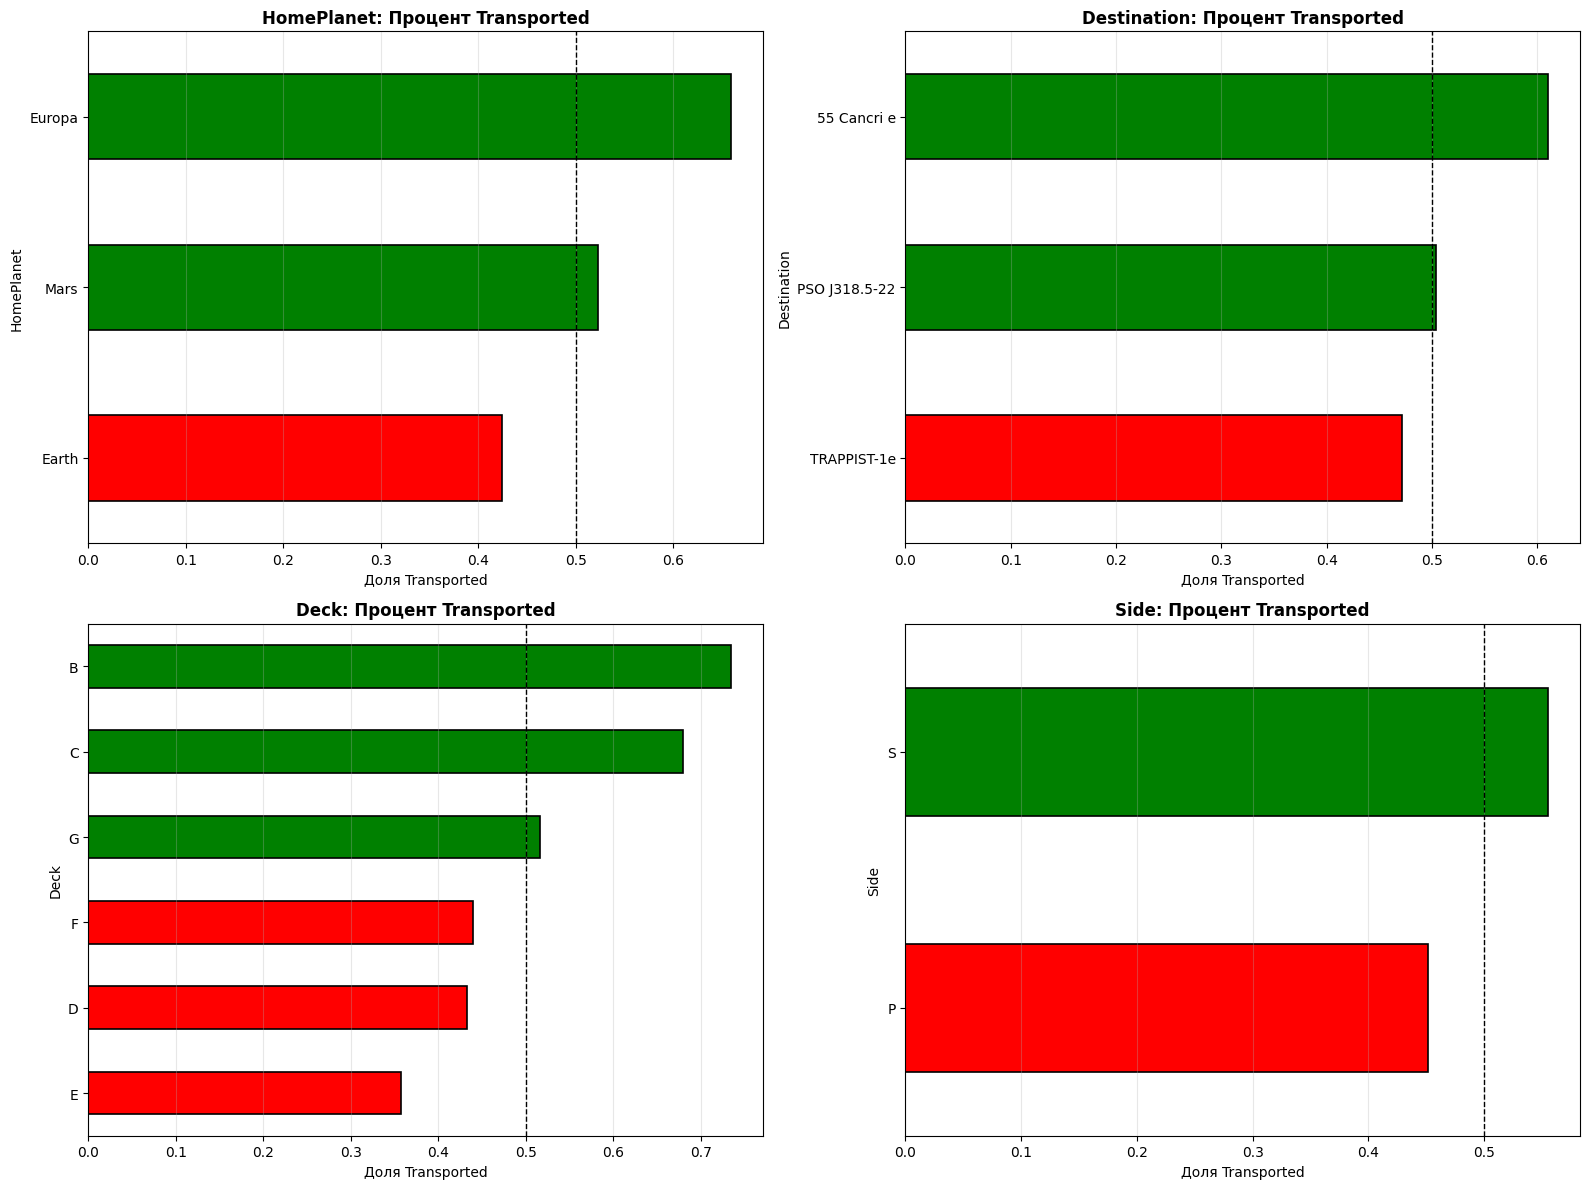

In [23]:
df_analysis = df.copy()
df_analysis[['Deck', 'Num', 'Side']] = df_analysis['Cabin'].str.split('/', expand=True)

homeplanet_threshold = find_optimal_threshold(df_analysis, 'HomePlanet', min_coverage=95, min_groups=2)

destination_threshold = find_optimal_threshold(df_analysis, 'Destination', min_coverage=95, min_groups=2)

deck_threshold = find_optimal_threshold(df_analysis, 'Deck', min_coverage=95, min_groups=5)

side_threshold = find_optimal_threshold(df_analysis, 'Side', min_coverage=95, min_groups=2)

hp_counts = df_analysis['HomePlanet'].value_counts()
hp_valid = hp_counts[hp_counts >= homeplanet_threshold].index.tolist()

dest_counts = df_analysis['Destination'].value_counts()
dest_valid = dest_counts[dest_counts >= destination_threshold].index.tolist()

deck_counts = df_analysis['Deck'].value_counts()
deck_valid = deck_counts[deck_counts >= deck_threshold].index.tolist()

side_counts = df_analysis['Side'].value_counts()
side_valid = side_counts[side_counts >= side_threshold].index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
hp_valid_df = df_analysis[df_analysis['HomePlanet'].isin(hp_valid)]
hp_transport = hp_valid_df.groupby('HomePlanet')['Transported'].mean().sort_values()
colors1 = ['green' if x > 0.5 else 'red' for x in hp_transport]
hp_transport.plot(kind='barh', ax=ax1, color=colors1, edgecolor='black', linewidth=1.2)
ax1.set_title('HomePlanet: Процент Transported', fontsize=12, weight='bold')
ax1.set_xlabel('Доля Transported')
ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)

ax2 = axes[0, 1]
dest_valid_df = df_analysis[df_analysis['Destination'].isin(dest_valid)]
dest_transport = dest_valid_df.groupby('Destination')['Transported'].mean().sort_values()
colors2 = ['green' if x > 0.5 else 'red' for x in dest_transport]
dest_transport.plot(kind='barh', ax=ax2, color=colors2, edgecolor='black', linewidth=1.2)
ax2.set_title('Destination: Процент Transported', fontsize=12, weight='bold')
ax2.set_xlabel('Доля Transported')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

ax3 = axes[1, 0]
deck_valid_df = df_analysis[df_analysis['Deck'].isin(deck_valid)]
deck_transport = deck_valid_df.groupby('Deck')['Transported'].mean().sort_values()
colors3 = ['green' if x > 0.5 else 'red' for x in deck_transport]
deck_transport.plot(kind='barh', ax=ax3, color=colors3, edgecolor='black', linewidth=1.2)
ax3.set_title('Deck: Процент Transported', fontsize=12, weight='bold')
ax3.set_xlabel('Доля Transported')
ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
ax3.grid(axis='x', alpha=0.3)

ax4 = axes[1, 1]
side_valid_df = df_analysis[df_analysis['Side'].isin(side_valid)]
side_transport = side_valid_df.groupby('Side')['Transported'].mean().sort_values()
colors4 = ['green' if x > 0.5 else 'red' for x in side_transport]
side_transport.plot(kind='barh', ax=ax4, color=colors4, edgecolor='black', linewidth=1.2)
ax4.set_title('Side: Процент Transported', fontsize=12, weight='bold')
ax4.set_xlabel('Доля Transported')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### Результаты анализа
На самом деле в ходе выполнения работы я проверил много вариантов обучения модели. 

Изначально это был просто Random Forest, а признаков в него шло всего 5, если не брать в расчёт target (именно в этом варианте я оставлял лишь HomePlanet и Deck, а также объединял все признаки, связанные с тратами в один признак HasSpending, кроме них оставались Age и CryoSleep). Но модель выдавала не самую высокую точность (0.73) даже с учетом кросс валидации и большой сетки параметров.

Из-за этого я сначала практически полностью отменил всю свою предобработку, буквально оставив почти все изначальные признаки, просто закодировав их, а также перешел от Random Forest к Stacking Classifier, поскольку сам по себе Random Forest после упрощения предобработки выдавал лишь 0.796 Accuracy, чего не хватало на полный балл. 

До того, как я пришел к Stacking Classifier много экспериментировал с Grid Search, Cross Validation, чтобы добиться лучшего результата, но вместо этого модель просто переобучалась, выдавая ещё меньшую точность от 0.793 до 0.795. Как ни странно, самые лучшие показатели точности выдали модели даже без сетки параметров и кросс валидации.

В результате 90% моей работы оказалось впустую, ведь по итогу фактически никакая предобработка не понадобилась, а основную роль сыграл крутой Stacking Classifier.

### Предобработка

In [17]:
def preprocess_final(df, is_train=True, fill_values=None, scaler=None):
    
    df_proc = df.copy()
    
    df_proc[['Deck', 'Num', 'Side']] = df_proc['Cabin'].str.split('/', expand=True)
    
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_cols:
        df_proc[col] = df_proc[col].fillna(0)
    
    if is_train:
        features = ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'Age', 'VIP',
                   'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                   'Transported']
    else:
        features = ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'Age', 'VIP',
                   'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    df_proc = df_proc[features].copy()
    print(f"Отобрано признаков: {len(features) - (1 if is_train else 0)}")
    
    # Обработка пропусков
    if is_train:
        fill_values = {}
        for col in ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'VIP']:
            if col in df_proc.columns and df_proc[col].isnull().sum() > 0:
                fill_values[col] = df_proc[col].mode()[0]
                df_proc[col] = df_proc[col].fillna(fill_values[col])
        
        if df_proc['Age'].isnull().sum() > 0:
            fill_values['Age'] = df_proc['Age'].median()
            df_proc['Age'] = df_proc['Age'].fillna(fill_values['Age'])
        
        print(f"Пропуски заполнены (train)")
    else:
        for col, value in fill_values.items():
            if col in df_proc.columns and df_proc[col].isnull().sum() > 0:
                df_proc[col] = df_proc[col].fillna(value)
        print(f"Пропуски заполнены значениями из train")
    
    # Кодирование категориальных 
    homeplanet_map = {'Earth': 0, 'Europa': 1, 'Mars': 2}
    df_proc['HomePlanet'] = df_proc['HomePlanet'].map(homeplanet_map)
    
    dest_map = {'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2}
    df_proc['Destination'] = df_proc['Destination'].map(dest_map)
    
    df_proc['CryoSleep'] = df_proc['CryoSleep'].map({False: 0, True: 1})
    
    df_proc['VIP'] = df_proc['VIP'].map({False: 0, True: 1})
    
    deck_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
    df_proc['Deck'] = df_proc['Deck'].map(deck_map)
    
    side_map = {'P': 0, 'S': 1}
    df_proc['Side'] = df_proc['Side'].map(side_map)
    
    # Transported (только train)
    if is_train:
        df_proc['Transported'] = df_proc['Transported'].map({False: 0, True: 1})
    
    print(f"Категориальные признаки закодированы")
    
    # StandardScaler для числовых признаков
    numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    if is_train:
        scaler = StandardScaler()
        df_proc[numeric_cols] = scaler.fit_transform(df_proc[numeric_cols])
        print(f"StandardScaler применён (fit)")
    else:
        if scaler is None:
            raise ValueError("Нужен scaler из train!")
        df_proc[numeric_cols] = scaler.transform(df_proc[numeric_cols])
        print(f"StandardScaler применён (transform)")
    
    print(f" Финальный размер: {df_proc.shape}")
    print(f" Пропусков: {df_proc.isnull().sum().sum()}")
    
    return df_proc, fill_values, scaler

df_train_final, fill_vals, scaler_fitted = preprocess_final(df_train_raw, is_train=True)
df_test_final, _, _ = preprocess_final(df_test_raw, is_train=False, fill_values=fill_vals, scaler=scaler_fitted)

X = df_train_final.drop('Transported', axis=1)
y = df_train_final['Transported']
X_test = df_test_final

print(f"\n X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}")

Отобрано признаков: 12
Пропуски заполнены (train)
Категориальные признаки закодированы
StandardScaler применён (fit)
 Финальный размер: (8693, 13)
 Пропусков: 0
Отобрано признаков: 12
Пропуски заполнены значениями из train
Категориальные признаки закодированы
StandardScaler применён (transform)
 Финальный размер: (4277, 12)
 Пропусков: 0

 X: (8693, 12), y: (8693,), X_test: (4277, 12)


C:\Users\pyc_nya\AppData\Local\Temp\ipykernel_18372\4272051663.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_proc[col] = df_proc[col].fillna(fill_values[col])
C:\Users\pyc_nya\AppData\Local\Temp\ipykernel_18372\4272051663.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_proc[col] = df_proc[col].fillna(value)


### Обучение модели

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Базовые модели (уровень 1)
base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)),
    ('svm', LinearSVC(max_iter=2000, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)),
    ('lgb', LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)),
    ('pa', PassiveAggressiveClassifier(max_iter=1000, random_state=42))
]

# Мета-модель (уровень 2)
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

print("\nОбучение Stacking (займёт время)...")
stacking.fit(X, y)

best_model = stacking

print("Stacking готов!")


Обучение Stacking (займёт время)...
Stacking готов!


### Применение модели к тестовым данным

In [19]:
y_test_pred = best_model.predict(X_test)
passenger_ids = df_test_raw['PassengerId'].copy()

print(f"\nПредсказания сделаны для {len(y_test_pred)} записей")
print(f"\nРаспределение предсказаний:")
print(pd.Series(y_test_pred).value_counts())

submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': y_test_pred.astype(bool)
})

print(f"\nSubmission DataFrame создан:")
print(f"Размер: {submission.shape}")

submission.to_csv('answer.csv', index=False)
print(f"\n Файл 'answer.csv' успешно создан!")

check_df = pd.read_csv('answer.csv')
print(f"Размер: {check_df.shape}")
print(f"Столбцы: {check_df.columns.tolist()}")


Предсказания сделаны для 4277 записей

Распределение предсказаний:
1    2389
0    1888
Name: count, dtype: int64

Submission DataFrame создан:
Размер: (4277, 2)

 Файл 'answer.csv' успешно создан!
Размер: (4277, 2)
Столбцы: ['PassengerId', 'Transported']
